<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [15]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

plt.rcParams['figure.figsize'] = [17, 8]

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-12-31 13:46:14--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2019-12-31 13:46:15 (13.0 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [130]:
df = pd.read_csv(
    'loan_train.csv',
    parse_dates=['effective_date', 'due_date'],
    dtype={'Principal': np.float64, 'terms': np.float64, 'age': np.float64}
)
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
df = df.sort_values(by='effective_date')
df = df.reset_index(drop=True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000.0,30.0,2016-09-08,2016-10-07,45.0,High School or Below,male
1,PAIDOFF,1000.0,30.0,2016-09-08,2016-10-07,33.0,Bechalor,female
2,PAIDOFF,1000.0,15.0,2016-09-08,2016-09-22,27.0,college,male
3,COLLECTION,800.0,15.0,2016-09-09,2016-09-23,27.0,college,male
4,COLLECTION,800.0,15.0,2016-09-09,2016-09-23,24.0,Bechalor,male


In [131]:
df_features = df.copy(deep=True)

# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [98]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [4]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.27 |                0         132 KB  anaconda
    seaborn-0.9.0              |     pyh91ea838_1         164 KB  anaconda
    openssl-1.1.1              |       h7b6447c_0         5.0 MB  anaconda
    certifi-2019.11.28         |           py36_0         156 KB  anaconda
    ------------------------------------------------------------
                                           Total:         5.5 MB

The following packages will be UPDATED:

    ca-certificates: 2019.11.27-0       --> 2019.11.27-0       anaconda
    certifi:         2019.11.28-py36_0  --> 2019.11.28-py36_0  anaconda
    openssl:         1.1.1d-h7b6447c_3  --> 1.1.1-h7b6447c_0   anaconda
    seaborn:         0.9.0-py

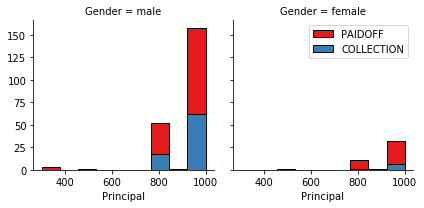

In [99]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

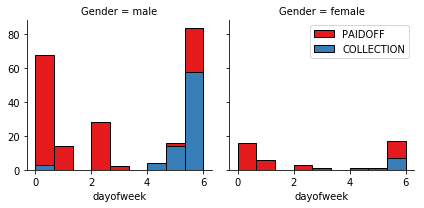

In [132]:
df_features['dayofweek'] = df_features['effective_date'].dt.dayofweek
bins = np.linspace(df_features.dayofweek.min(), df_features.dayofweek.max(), 10)
g = sns.FacetGrid(df_features, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [133]:
df_features['weekend'] = df_features['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df_features.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000.0,30.0,2016-09-08,2016-10-07,45.0,High School or Below,male,3,0
1,PAIDOFF,1000.0,30.0,2016-09-08,2016-10-07,33.0,Bechalor,female,3,0
2,PAIDOFF,1000.0,15.0,2016-09-08,2016-09-22,27.0,college,male,3,0
3,COLLECTION,800.0,15.0,2016-09-09,2016-09-23,27.0,college,male,4,1
4,COLLECTION,800.0,15.0,2016-09-09,2016-09-23,24.0,Bechalor,male,4,1


## Create bins of features that we expect same behavior

### Take a look at the age feature

We expect that people with the same age should behaive on the same way

[18.  24.6 31.2 37.8 44.4 51. ]


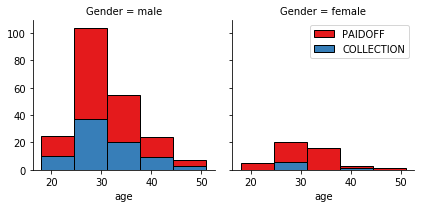

In [134]:
df_features.groupby(['loan_status'])['age'].value_counts(normalize=True)

bins = np.linspace(df_features.age.min(), df_features.age.max(), 6)
print(bins)
g = sns.FacetGrid(df_features, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


On the previous example we group male and female in five groups: [18-24.6], [24.6-31.2], [31.2-37.8], [37.8-44.4], [44.4-51]

However, we don't know how the grouping will influence the model behavior by just loking into the numbers. Therefore, we will evaluate the model performance for each group later at the training phase.

## Convert Categorical features to numerical values

Lets look at gender:

In [135]:
df_features.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [136]:
df_features['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df_features.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000.0,30.0,2016-09-08,2016-10-07,45.0,High School or Below,0,3,0
1,PAIDOFF,1000.0,30.0,2016-09-08,2016-10-07,33.0,Bechalor,1,3,0
2,PAIDOFF,1000.0,15.0,2016-09-08,2016-09-22,27.0,college,0,3,0
3,COLLECTION,800.0,15.0,2016-09-09,2016-09-23,27.0,college,0,4,1
4,COLLECTION,800.0,15.0,2016-09-09,2016-09-23,24.0,Bechalor,0,4,1


## Avoid Bias

### Rescale

Lets take a look in the Prinvcipal feature.

In [137]:
df_features.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000.0,30.0,2016-09-08,2016-10-07,45.0,High School or Below,0,3,0
1,PAIDOFF,1000.0,30.0,2016-09-08,2016-10-07,33.0,Bechalor,1,3,0
2,PAIDOFF,1000.0,15.0,2016-09-08,2016-09-22,27.0,college,0,3,0
3,COLLECTION,800.0,15.0,2016-09-09,2016-09-23,27.0,college,0,4,1
4,COLLECTION,800.0,15.0,2016-09-09,2016-09-23,24.0,Bechalor,0,4,1


After remove all date features and transform the categorical to numeric feature, most of its values will be between 0 and 10, so the Principal values will be too large, as consequence, it may create bias.

To avoid this kind of misbehavior, we can use an scaler in the column as folow.

In [138]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df_features['Principal'] = scaler.fit_transform(df_features['Principal'].values.reshape(-1, 1))

df_features.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1.000000,30.0,2016-09-08,2016-10-07,45.0,High School or Below,0,3,0
1,PAIDOFF,1.000000,30.0,2016-09-08,2016-10-07,33.0,Bechalor,1,3,0
2,PAIDOFF,1.000000,15.0,2016-09-08,2016-09-22,27.0,college,0,3,0
3,COLLECTION,0.714286,15.0,2016-09-09,2016-09-23,27.0,college,0,4,1
4,COLLECTION,0.714286,15.0,2016-09-09,2016-09-23,24.0,Bechalor,0,4,1


## One Hot Encoding  
#### How about education?

In [139]:
df_features.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [140]:
df_features[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1.000000,30.0,45.0,0,High School or Below
1,1.000000,30.0,33.0,1,Bechalor
2,1.000000,15.0,27.0,0,college
3,0.714286,15.0,27.0,0,college
4,0.714286,15.0,24.0,0,Bechalor


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [141]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 10 columns):
loan_status       346 non-null object
Principal         346 non-null float64
terms             346 non-null float64
effective_date    346 non-null datetime64[ns]
due_date          346 non-null datetime64[ns]
age               346 non-null float64
education         346 non-null object
Gender            346 non-null int64
dayofweek         346 non-null int64
weekend           346 non-null int64
dtypes: datetime64[ns](2), float64(3), int64(3), object(2)
memory usage: 27.1+ KB


In [142]:
Feature = df_features[df_features.columns.difference(['loan_status', 'effective_date', 'due_date', 'dayofweek', 'education'])]
Feature = df_features[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df_features['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1.000000,30.0,45.0,0,0,0,1,0
1,1.000000,30.0,33.0,1,0,1,0,0
2,1.000000,15.0,27.0,0,0,0,0,1
3,0.714286,15.0,27.0,0,1,0,0,1
4,0.714286,15.0,24.0,0,1,1,0,0


#### Lets analize the payment terms

In [143]:
df_features.groupby(['Gender'])['terms'].value_counts(normalize=True)

Gender  terms
0       30.0     0.537415
        15.0     0.425170
        7.0      0.037415
1       30.0     0.500000
        15.0     0.442308
        7.0      0.057692
Name: terms, dtype: float64

In [144]:
df_features.groupby(['loan_status'])['terms'].value_counts(normalize=True)

loan_status  terms
COLLECTION   30.0     0.604651
             15.0     0.395349
PAIDOFF      30.0     0.507692
             15.0     0.438462
             7.0      0.053846
Name: terms, dtype: float64

As can see, the payment terms is one of those three values: 30, 15, 7
Therefore, we can see the term feature as categorical instead of continuous.

By usimg the pandas get_dummies funcion we can redefine the input feature to the One Hot Encode Format.

In [145]:
Feature = pd.get_dummies(Feature, columns=['terms'])
Feature.head()

,Principal,age,Gender,weekend,Bechalor,High School or Below,college,terms_7.0,terms_15.0,terms_30.0
0,1.000000,45.0,0,0,0,1,0,0,0,1
1,1.000000,33.0,1,0,1,0,0,0,0,1
2,1.000000,27.0,0,0,0,0,1,0,1,0
3,0.714286,27.0,0,1,0,0,1,0,1,0
4,0.714286,24.0,0,1,1,0,0,0,1,0


### Feature selection

Lets defind feature sets, X:

In [146]:
X = Feature
X[0:5]

,Principal,age,Gender,weekend,Bechalor,High School or Below,college,terms_7.0,terms_15.0,terms_30.0
0,1.000000,45.0,0,0,0,1,0,0,0,1
1,1.000000,33.0,1,0,1,0,0,0,0,1
2,1.000000,27.0,0,0,0,0,1,0,1,0
3,0.714286,27.0,0,1,0,0,1,0,1,0
4,0.714286,24.0,0,1,1,0,0,0,1,0


What are our lables?

In [148]:
y = df_features['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'COLLECTION'],
      dtype=object)

## Preprocessing Phase

To simplify the preprocessing phase, I create one function for each data transformation and one function that creates a pipe with all prepprocessing steps. It allow me to run the same steps with a clean dataset for each model.

***Obs:*** Since the usage of OneHotEncoder results on a sparsed matrix, I decide to use the LabelEncoder instead for `education`, `terms` and `Gender`. In the end, this approach gave a better performace than the previous one.

In [6]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, KBinsDiscretizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split

def set_weekend(df):
    aux = pd.DataFrame()
    aux['dayofweek'] = df['effective_date'].dt.dayofweek
    df['weekend'] = aux['dayofweek'].apply(lambda x: 1 if (x>3) else 0)
    return df

def one_hot_encoder(df, columns):
    return pd.get_dummies(df, columns=columns, drop_first=True)

def label_encoder(df, columns):
    le = LabelEncoder()
    df[columns] = df[columns].apply(lambda x: le.fit_transform(x))
    return df

def scale(df, columns, scaler):
    df[columns] = scaler.fit_transform(df[columns])
    return df

def standard_scaler(df, columns):
    return scale(df, columns, StandardScaler())

def min_max_scaler(df, columns):
    return scale(df, columns, MinMaxScaler())

def kbins_discretizer(df, columns, n_bins=3, strategy='uniform', encode='ordinal'):
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy)
    df[columns] = discretizer.fit_transform(df[columns])
    return df

def drop_columns(df, columns):
    return df.drop(columns=columns, axis=0)

def split(df, class_column, test_size=0.7):
    y = df[class_column].values
    X = df[df.columns.difference([class_column])].values
    return train_test_split(X, y, test_size=test_size)

In [53]:
%%time

columns_to_drop = ['effective_date', 'due_date']
class_column = 'loan_status'

def process_data(n_bins, df_ref=df.copy(deep=True), should_split=True):
    df_ref = (
        df_ref.pipe(set_weekend)
        .pipe(drop_columns, columns_to_drop)
        .pipe(min_max_scaler, ['Principal'])
        .pipe(kbins_discretizer, ['age'], n_bins)
        .pipe(label_encoder, ['education', 'terms', 'Gender'])
        .pipe(standard_scaler, df_neigh.columns.difference(columns_to_drop + [class_column]))
    )
    
    if should_split:
        return df_ref.pipe(split, class_column)
    else:
        return df_ref

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 454 µs


# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

Since every run of KNN Classifier may return a different result, I'll run it 1000 times and analise its behavior to define the "best" number of eighbors.

CPU times: user 9min 52s, sys: 600 ms, total: 9min 53s
Wall time: 10min 1s


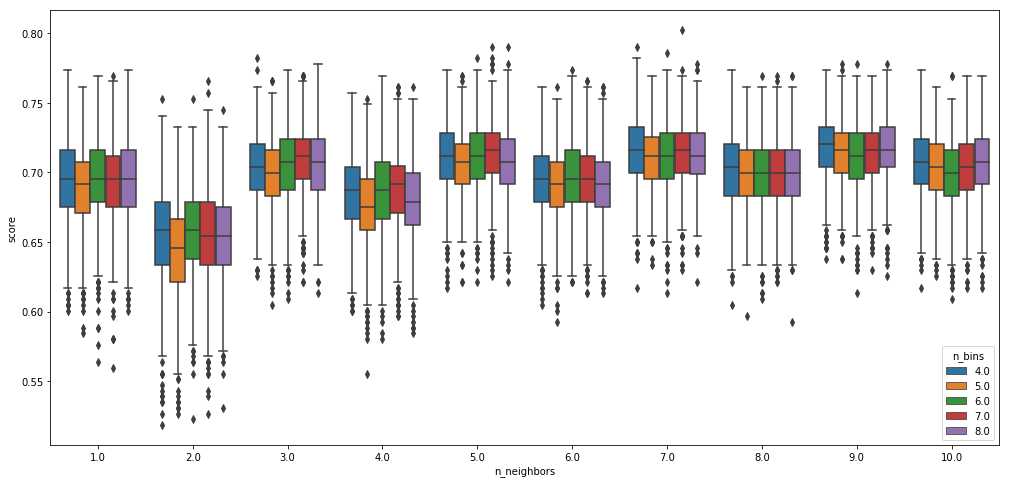

In [17]:
%%time
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore") #, category=DeprecationWarning)

neighs = [KNeighborsClassifier(n_neighbors=n) for n in range(1, 11)]
scores = pd.DataFrame(columns=['n_neighbors', 'n_bins', 'score'])

for epoch in range(1000):
    for n_bins in range(4, 9):
        X_train, X_test, y_train, y_test = process_data(n_bins)

        for pos, neigh in enumerate(neighs):
            knn = neigh.fit(X_train, y_train)
            scores = scores.append({'n_neighbors': pos+1, 'n_bins': n_bins, 'score': knn.score(X_test, y_test)}, ignore_index=True)

sns.boxplot(data=scores, x='n_neighbors', y='score', hue='n_bins')

As can be seen in the chart above, the "best" results are achieved with 9 neighbors and 4 bins.

In [21]:
%%time

neigh = KNeighborsClassifier(n_neighbors=9)

X_train, X_test, y_train, y_test = process_data(4)
knn = neigh.fit(X_train, y_train)

print(knn.score(X_test, y_test))

0.7407407407407407
CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 42.2 ms


# Decision Tree

For the decision tree classifier, I decide to let the library handle the hyperparameters, such as 'max_leaf_nodes' or 'max_depth', which, in most cases are defined as None, because the volume of data is too little and I could cutoff important branchs or features.

Therefore, the only parameter evaluated here is the number of bins.

***obs:*** I used the same epoch approach as the previous classifier.

CPU times: user 3min 56s, sys: 592 ms, total: 3min 57s
Wall time: 3min 59s


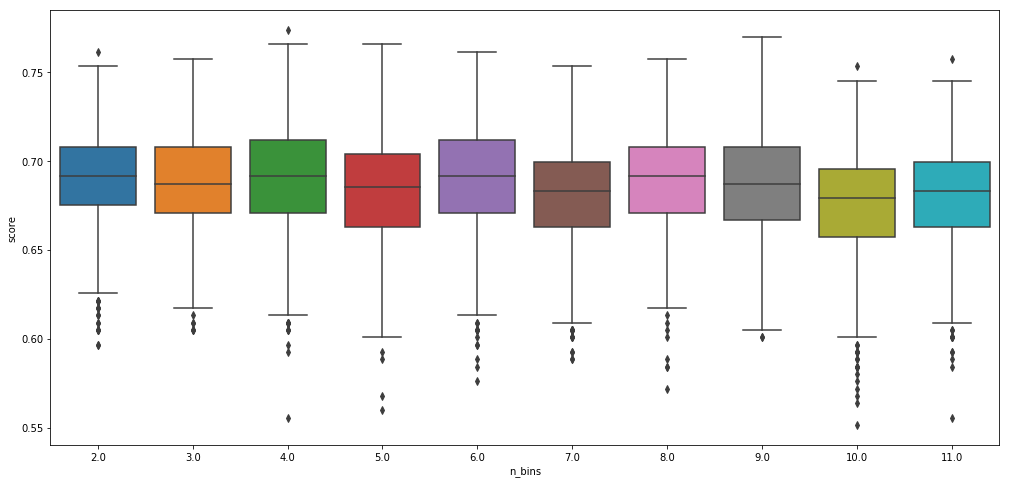

In [22]:
%%time

from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore") #, category=DeprecationWarning)

decision_tree = DecisionTreeClassifier(random_state=0)
scores = pd.DataFrame(columns=['n_bins', 'score'])

for epoch in range(1000):
    for n_bins in range(2, 12):
        X_train, X_test, y_train, y_test = process_data(n_bins)

        tree = decision_tree.fit(X_train, y_train)
        scores = scores.append({'n_bins': n_bins, 'score': tree.score(X_test, y_test)}, ignore_index=True)

sns.boxplot(data=scores, x='n_bins', y='score')

Here, we can see the "best" fit is 9 biins because it has only a few outlyers, given that the behavior in each bin-case is very much alike.

In [27]:
X_train, X_test, y_train, y_test = process_data(9)

tree = decision_tree.fit(X_train, y_train)
print(tree.score(X_test, y_test))

0.720164609053498


# Support Vector Machine

CPU times: user 9min 33s, sys: 1.31 s, total: 9min 34s
Wall time: 9min 43s


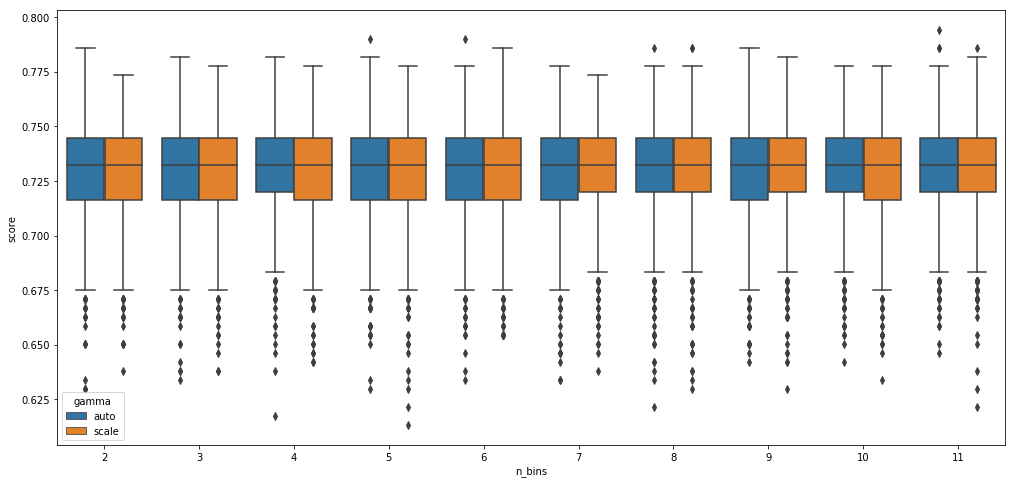

In [41]:
%%time

from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore") #, category=DeprecationWarning)

scores = pd.DataFrame(columns=['n_bins', 'score', 'gamma'])

for gamma in ['auto', 'scale']:
    svc = SVC(gamma=gamma)
    for epoch in range(1000):
        for n_bins in range(2, 12):
            X_train, X_test, y_train, y_test = process_data(n_bins)

            svm = svc.fit(X_train, y_train)
            scores = scores.append({'n_bins': n_bins, 'gamma': gamma, 'score': svm.score(X_test, y_test)}, ignore_index=True)

sns.boxplot(data=scores, x='n_bins', y='score', hue='gamma')

CPU times: user 19min 28s, sys: 3.34 s, total: 19min 31s
Wall time: 19min 49s


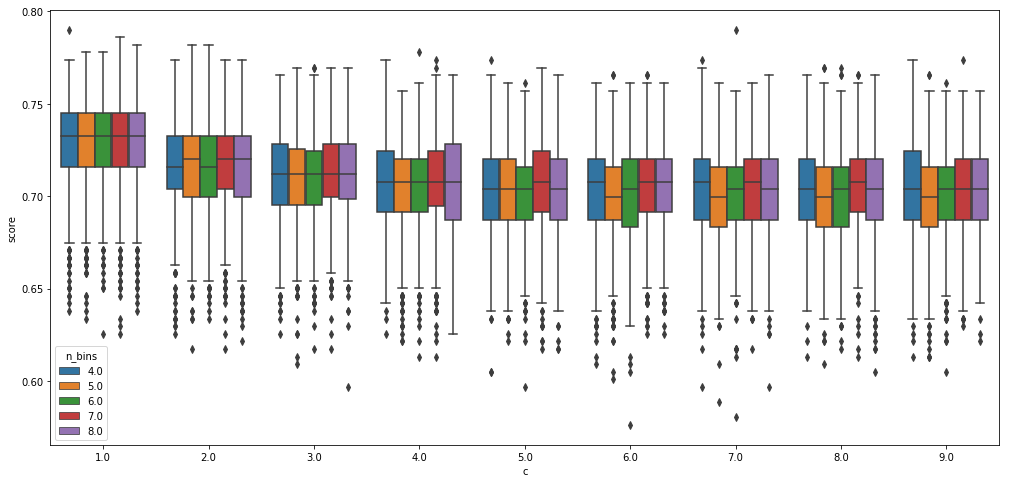

In [42]:
%%time

from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore") #, category=DeprecationWarning)

scores = pd.DataFrame(columns=['n_bins', 'score', 'c'])

for c in range(1, 10):
    svc = SVC(C=c, gamma='auto')
    for epoch in range(1000):
        for n_bins in range(4, 9):
            X_train, X_test, y_train, y_test = process_data(n_bins)

            svm = svc.fit(X_train, y_train)
            scores = scores.append({'n_bins': n_bins, 'c': c, 'score': svm.score(X_test, y_test)}, ignore_index=True)

sns.boxplot(data=scores, x='c', y='score', hue='n_bins')

Since the increasing of the parameter C causes the score decrease, it's better use the default value 1.0.

In [55]:
%%time

from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore") #, category=DeprecationWarning)

svc = SVC(C=c, gamma='auto')
X_train, X_test, y_train, y_test = process_data(4)
svm = svc.fit(X_train, y_train)
print(svm.score(X_test, y_test))

0.7283950617283951
CPU times: user 32 ms, sys: 4 ms, total: 36 ms
Wall time: 40 ms


# Logistic Regression

CPU times: user 18min 52s, sys: 3.24 s, total: 18min 55s
Wall time: 19min 13s


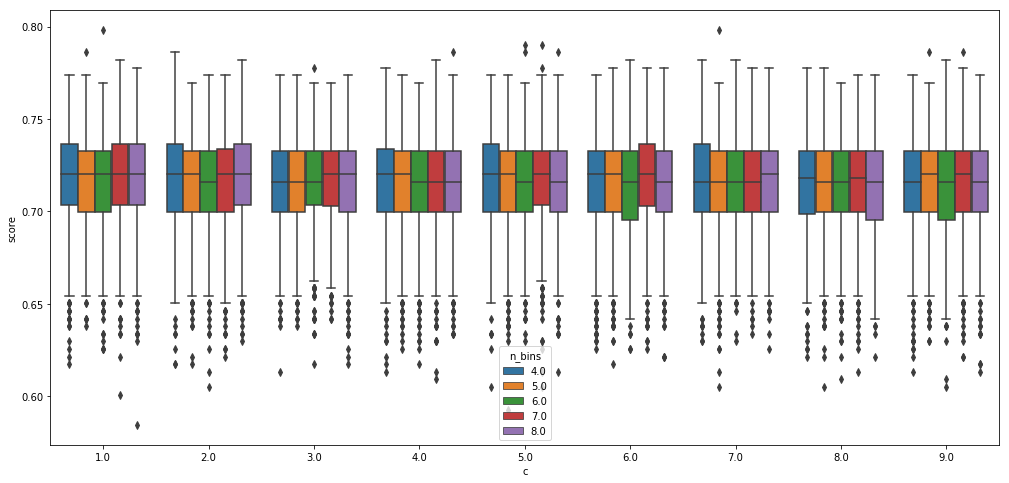

In [43]:
%%time

from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore") #, category=DeprecationWarning)

scores = pd.DataFrame(columns=['n_bins', 'score', 'c'])

for c in range(1, 10):
    lr = LogisticRegression(random_state=0, C=c)
    for epoch in range(1000):
        for n_bins in range(4, 9):
            X_train, X_test, y_train, y_test = process_data(n_bins)

            lr = lr.fit(X_train, y_train)
            scores = scores.append({'n_bins': n_bins, 'c': c, 'score': lr.score(X_test, y_test)}, ignore_index=True)

sns.boxplot(data=scores, x='c', y='score', hue='n_bins')

In [46]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0)
X_train, X_test, y_train, y_test = process_data(4)

lr = lr.fit(X_train, y_train)
print(lr.score(X_test, y_test))

0.7325102880658436


# Model Evaluation using Test set

In [47]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [48]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-12-31 18:37:23--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-12-31 18:37:24 (368 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [50]:
df_test = pd.read_csv(
    'loan_test.csv',
    parse_dates=['effective_date', 'due_date'],
    dtype={'Principal': np.float64, 'terms': np.float64, 'age': np.float64}
)
df_test = df_test.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
df_test = df_test.sort_values(by='effective_date')
df_test = df_test.reset_index(drop=True)
df_test.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000.0,30.0,2016-09-08,2016-10-07,50.0,Bechalor,female
1,COLLECTION,1000.0,30.0,2016-09-09,2016-10-08,33.0,High School or Below,male
2,PAIDOFF,300.0,7.0,2016-09-09,2016-09-15,35.0,Master or Above,male
3,COLLECTION,1000.0,15.0,2016-09-10,2016-09-24,31.0,High School or Below,female
4,COLLECTION,1000.0,15.0,2016-09-10,2016-10-09,26.0,High School or Below,male


In [57]:
df_process = process_data(n_bins=4, df_ref=df_test.copy(deep=True), should_split=False)
df_process.head()

,loan_status,Principal,terms,age,education,Gender,weekend
0,PAIDOFF,0.493626,0.870285,2.130072,-1.503663,-1.977142,-1.303840
1,COLLECTION,0.493626,0.870285,-0.170406,-0.639857,0.505781,0.766965
2,PAIDOFF,-3.562691,-2.066928,0.979833,0.223950,0.505781,0.766965
3,COLLECTION,0.493626,-0.598321,-0.170406,-0.639857,-1.977142,0.766965
4,COLLECTION,0.493626,-0.598321,-1.320644,-0.639857,0.505781,0.766965


In [79]:
y = df_process['loan_status']
# y = y.apply(lambda ls: 1 if ls == 'PAIDOFF' else 0)
X = df_process[df_process.columns.difference(['loan_status'])]
print(X.columns)
print(y.head())

Index(['Gender', 'Principal', 'age', 'education', 'terms', 'weekend'], dtype='object')
0       PAIDOFF
1    COLLECTION
2       PAIDOFF
3    COLLECTION
4    COLLECTION
Name: loan_status, dtype: object


In [92]:
def print_metrics(model, with_loss=False):
    predicted = model.predict(X)
    print(
        f1_score(y, predicted, average='weighted', labels=['PAIDOFF', 'COLECTION']),
        jaccard_similarity_score(y, predicted)
    )
    
    if with_loss:
        predicted = model.predict_proba(X)
        print(log_loss(y, predicted))

In [93]:
print_metrics(knn)
print_metrics(tree)
print_metrics(svm)
print_metrics(lr, True)

0.7804878048780488 0.6666666666666666
0.8101265822784811 0.7222222222222222
0.8095238095238095 0.7037037037037037
0.851063829787234 0.7407407407407407
0.4944919547966385


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.66666 | 0.78048  | NA      |
| Decision Tree      | 0.72222 | 0.81012  | NA      |
| SVM                | 0.70370 | 0.80952  | NA      |
| LogisticRegression | 0.74074 | 0.85106  | 0.49449 |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>